# Hangar Tutorial 

## Part 1: Begining

This tutorial will review the first steps of working with a hangar repository. 

To fit with the beginner's theme, we will use the MNIST dataset. Later examples will show off how to work with much more complex data.

In [1]:
from hangar import Repository

import numpy as np
import pickle
import gzip
import matplotlib.pyplot as plt

from tqdm import tqdm

### Creating & Interacting with a Hangar Repository

Hangar is designed to "just make sense" in every operation you have to perform. As such, there is a single interface which all interaction begins with:
the `Repository` object. 

Weather a hangar repository exists at the path you specify or not, just tell hangar where it should live!

#### Intitializing a repository

The first time you want to work with a new repository, the `init()` method must be called. This is where you provide hangar with your name and email address (to be used in the commit log), as well as implicitly confirming that you do want to create the underlying data files hangar uses on disk. 

In [2]:
repo = Repository(path='/Users/rick/projects/tensorwerk/hangar/dev/intro/')

repo.init(user_name='Rick Izzo', user_email='rick@tensorwerk.com', remove_old=True)

HANGAR RUNTIME WARNING: no repository exists at /Users/rick/projects/tensorwerk/hangar/dev/intro/__hangar, please use `init_repo` function
Hangar Repo initialized at: /Users/rick/projects/tensorwerk/hangar/dev/intro/__hangar


'/Users/rick/projects/tensorwerk/hangar/dev/intro/__hangar'

#### A look at the repository object

In [3]:
repo

            
 Hangar Repository            
     Repository Path  : /Users/rick/projects/tensorwerk/hangar/dev/intro/__hangar            
     Writer-Lock Free : True


In [4]:
repo.repo_path

'/Users/rick/projects/tensorwerk/hangar/dev/intro'

In [ ]:
repo.writer_lock_held

### Checking out the repo for writing

A repository can be checked out in two modes: 

1) **write-enabled**: applies all operations to the staging area's current state. Only one write-enabled checkout can be active at a different time, must be closed upon last use, or manual intervention will be needed to remove the writer lock. 
    
2) **read-only**: checkout a commit or branch to view repository state as it existed at that point in time. 

In [5]:
co = repo.checkout(write=True)

#### Lots of useful information is in the ipython `__repr__`

#### A checkout allows access to `datasets` and `metadata`

In [6]:
co.metadata


 Hangar Metadata                
     Writeable: True                
     Number of Keys: 0


In [7]:
co.datasets


 Hangar Datasets                
     Writeable: True                
     Dataset Names:                
       - 

#### let's load the MNIST data set...

In [8]:
# Load the dataset
with gzip.open('/Users/rick/projects/tensorwerk/hangar/dev/data/mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='bytes')

def rescale(array):
    array = array * 256
    rounded = np.round(array)
    return rounded.astype(np.uint8())

sample_trimg = rescale(train_set[0][0])
sample_trlabel = np.array([train_set[1][0]])
trimgs = rescale(train_set[0])
trlabels = train_set[1]

#### Before data can be added to a repository, a dataset must be initialized. 

A Dataset is a named grouping of data samples where each sample shares a number of similar attributes and array properties:

https://hangar-py.readthedocs.io/en/latest/concepts.html#how-hangar-thinks-about-data

In [10]:
trimgs[0].dtype

dtype('uint8')

In [11]:
co.datasets.init_dataset(name='mnist_training_images', prototype=trimgs[0])

Dataset Specification:: Name: `mnist_training_images`, Initialization style: `prototype`, Shape: `(784,)`, DType: `uint8`, Samples Named: `True`, Variable Shape: `False`, Max Shape: `(784,)`
Dataset Initialized: `mnist_training_images`



 Hangar DatasetDataWriter                 
    Dataset Name     : mnist_training_images                
    Schema UUID      : ade5f7747db511e99c208c859047adef                
    Schema Hash      : 976ba57033bb                
    Variable Shape   : False                
    (max) Shape      : (784,)                
    Datatype         : <class 'numpy.uint8'>                
    Named Samples    : True                
    Access Mode      : a                
    Num Samples      : 0


In [12]:
co.datasets


 Hangar Datasets                
     Writeable: True                
     Dataset Names:                
       - mnist_training_images

In [13]:
co.datasets['mnist_training_images']


 Hangar DatasetDataWriter                 
    Dataset Name     : mnist_training_images                
    Schema UUID      : ade5f7747db511e99c208c859047adef                
    Schema Hash      : 976ba57033bb                
    Variable Shape   : False                
    (max) Shape      : (784,)                
    Datatype         : <class 'numpy.uint8'>                
    Named Samples    : True                
    Access Mode      : a                
    Num Samples      : 0


### Interaction 

When a dataset is initialized, a dataset accessor object will be returned, however, depending on your use case, this may or may not be the most convenient way to access a dataset.

In general, we have implemented a full `dict` mapping interface ontop of all object. To access the `'mnist_training_images'` dataset you can just use a dict style access like the following (note: if operating in ipython/jupyter, the dataset keys will autocomplete for you).

In [14]:
train_dset = co.datasets['mnist_training_images']

the full dictionary style mapping interface is implemented

#### Adding Data

To add data to a named dataset, we can use dict-style setting, or the `.add` method.

In [15]:
train_dset['0'] = trimgs[0]
train_dset.add(data=trimgs[1], name='1')

train_dset['51'] = trimgs[51]

#### How many samples are in the dataset?

In [16]:
len(train_dset)

3

#### containment testing

In [17]:
'hi' in train_dset

False

In [18]:
'0' in train_dset

True

#### Dictionary Style Retrieval for known keys

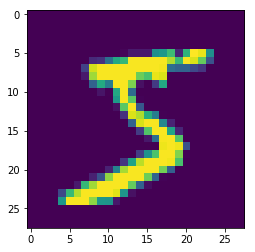

In [19]:
out = train_dset['0']
plt.imshow(out.reshape(28, 28))

In [20]:
train_dset


 Hangar DatasetDataWriter                 
    Dataset Name     : mnist_training_images                
    Schema UUID      : ade5f7747db511e99c208c859047adef                
    Schema Hash      : 976ba57033bb                
    Variable Shape   : False                
    (max) Shape      : (784,)                
    Datatype         : <class 'numpy.uint8'>                
    Named Samples    : True                
    Access Mode      : a                
    Num Samples      : 3


### Dict style iteration supported out of the box

0
1
51


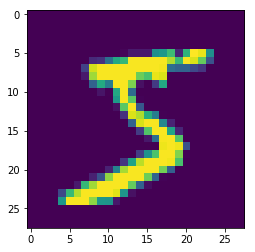

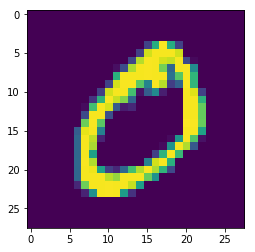

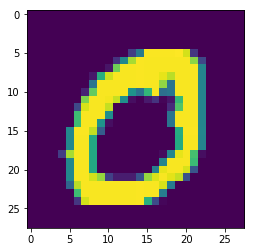

In [21]:
for k in train_dset:   
    # equivalent method: for k in train_dset.keys():
    print(k)
    
    
for v in train_dset.values():
    plt.imshow(v.reshape(28, 28))
    plt.show()
    
myDict = {}
for k, v in train_dset.items():
    myDict[k] = v

#### Performance

Once you've completed an interactive exploration, be sure to use the context manager form of the `.add` and `.get` methods! 

In order to make sure that all your data is always safe in Hangar, the backend dilligently ensures that all contexts are opened and closed appropriatly. 

When you use the context manager form of a dataset object, we can offload a significat amount of work to the python runtime, and dramatically increase read and write speeds.

Most datasets we've tested see an increased throughput differential of ~250% for writes and ~300% for reads when comparing using the context manager form vs the naked form!

In [22]:
dset_trimgs = co.datasets.init_dataset(name='train_images', prototype=sample_trimg, samples_are_named=True)
dset_trlabels = co.datasets.init_dataset(name='train_labels', prototype=sample_trlabel, samples_are_named=True)

pbar = tqdm(total=trimgs.shape[0])
with dset_trimgs, dset_trlabels:
    for idx, img in enumerate(trimgs):
        if (idx % 500 == 0):
            pbar.update(500)

        dset_trimgs.add(data=img, name=str(idx))
        dset_trlabels.add(data=np.array([trlabels[idx]]), name=str(idx))
        
pbar.close()

Dataset Specification:: Name: `train_images`, Initialization style: `prototype`, Shape: `(784,)`, DType: `uint8`, Samples Named: `True`, Variable Shape: `False`, Max Shape: `(784,)`
Dataset Initialized: `train_images`
Dataset Specification:: Name: `train_labels`, Initialization style: `prototype`, Shape: `(1,)`, DType: `int64`, Samples Named: `True`, Variable Shape: `False`, Max Shape: `(1,)`
Dataset Initialized: `train_labels`


100%|██████████| 50000/50000 [00:14<00:00, 3275.76it/s]


## Commiting Changes

Once you have made a set of changes you wan't to commit, just simply call the `commit()` method (and pass in a message)!

In [23]:
co.commit('hello world, this is my first hangar commit')

Commit operation requested with message: hello world, this is my first hangar commit
(6478676, 1570825, 65536)
removing all stage hash records
Commit completed. Commit hash: 7e6e09fcb4cc781f3ab0f5f59652b09bb9312980


'7e6e09fcb4cc781f3ab0f5f59652b09bb9312980'

In [24]:
repo.log\

* 7e6e09fcb4cc781f3ab0f5f59652b09bb9312980 (master) : hello world, this is my first hangar commit


### Any number of readers can check out any number of commits at any time

In [25]:
rco = repo.checkout()

 * Checking out BRANCH: master with current HEAD: 7e6e09fcb4cc781f3ab0f5f59652b09bb9312980


#### Readers can't ever influce data, once committed, the references are permenant and cannot be modified in any way

In [26]:
rdset = rco.datasets['train_images']

In [27]:
del rdset['0']

TypeError: 'DatasetDataReader' object does not support item deletion

### A writer will never influence any of the other readers!

In [28]:
co.metadata['Buffalo'] = 'Game Space Rocks!'
del co.datasets['train_images']['0']

In [29]:
co.datasets['train_images']['0']

'HANGAR KEY ERROR:: data: 0 not in dset: train_images'


KeyError: 'HANGAR KEY ERROR:: data: 0 not in dset: train_images'

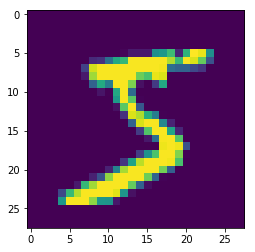

In [30]:
plt.imshow(rdset['0'].reshape(28, 28))

In [32]:
rco.metadata['Buffalo']

'HANGAR KEY ERROR:: No metadata key: `Buffalo` exists in checkout'


KeyError: 'HANGAR KEY ERROR:: No metadata key: `Buffalo` exists in checkout'

In [33]:
co.commit('some other commits over here')

Commit operation requested with message: some other commits over here
(6478677, 1570876, 65536)
removing all stage hash records
Commit completed. Commit hash: 8d9db2b611edc3bd7a268131c31da53e6f515b54


'8d9db2b611edc3bd7a268131c31da53e6f515b54'

### Safety from python "oddities" is built in Hangar's very essense.

- Unknown to the user, Hangar does not actually allow `dataset` or `metadata` objects to be directly referenced in application code.
- What you actually get is a `weakref ObjectProxy`. Though semantically identicaly, only Hangar keeps strong references to it's accessors.
- When a Hangar object no longer has permissions to act, the `ObjectProxy` "self destructs".
- Any introspection/call/modification by application code immediatly raises an exception to let you know you're dealing with something which is out of date! 

In [34]:
md_reference = co.metadata

In [35]:
md_reference


 Hangar Metadata                
     Writeable: True                
     Number of Keys: 1


In [36]:
md_reference['Buffalo']

'Game Space Rocks!'

In [37]:
dataset_reference = co.datasets

In [38]:
dataset_reference


 Hangar Datasets                
     Writeable: True                
     Dataset Names:                
       - mnist_training_images
       - train_images
       - train_labels

In [39]:
dataset_reference.keys()

dict_keys(['mnist_training_images', 'train_images', 'train_labels'])

In [40]:
dataset_reference.iswriteable

True

In [41]:
co.close()

writer checkout of master closed


In [42]:
dataset_reference.keys()

ReferenceError: weakly-referenced object no longer exists

In [44]:
dataset_reference

ReferenceError: weakly-referenced object no longer exists

In [46]:
md_reference['Buffalo']

ReferenceError: weakly-referenced object no longer exists

In [47]:
dir(md_reference)

[]

## What you put in is what you get out

- All data is hashed by cryptographically secure hash algorithms (`blake2b` with 20byte digest length)
- A commit is entirely self sufficient, and it's hash depends on the hash of previous references

For performance reasons, data hash is only calculated / verified when:
- a sample is added to a dataset
- data is fetched from a remote repo
- data is sent to a remote repo

During regular read access, data integrity is ensured via fletcher32 / crc32 checksums 
- Backend store utilities provide well validated, trusted, and performant implementations

In [48]:
repo.log()

* 8d9db2b611edc3bd7a268131c31da53e6f515b54 (master) : some other commits over here
* 7e6e09fcb4cc781f3ab0f5f59652b09bb9312980 : hello world, this is my first hangar commit


### Security Disclosure

Hangar is an early stage products, none of the core developers have any significant cryptography or security background/experience. While efforts have been made to secure application data, we are not comfortable calling Hangar a `cryptographically secure utility` until a formal security and design review by domain experts has been performed. 

We are actively looking for help in this area, if you are interested in contributing, please let us know!